# Differential gene expression analysis in two brain regions

JuGEx performs differential gene expresssion in two different brain regions, as described in the publication

> *Sebastian Bludau, Thomas W. Mühleisen, Simon B. Eickhoff, Michael J. Hawrylycz, Sven Cichon, Katrin Amunts. Integration of transcriptomic and cytoarchitectonic data implicates a role for MAOA and TAC1 in the limbic-cortical network. 2018, Brain Structure and Function. https://doi.org/10.1007/s00429-018-1620-6*

For the gene expression data, `siibra` accesses the Allen Brain Atlas API (© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: brain-map.org/api/index.html). 

### Initialize the analysis

The analysis is initialized with a `siibra` atlas object. It will check if the parcellation selected in the atlas is suitable for performing the analysis, which includes to verify that the given atlas object provides maps in the MNI ICBM 152 space. We explicitely select the Julich-Brain probabilistic cytoarchitectonic maps, and  tell the atlas to threshold the probability maps for filtering gene expressions instead of using the simplified labelled volume. 

In [1]:
import siibra==0.1a8, siibra_jugex==0.1a2

[siibra:INFO]  Version: 0.1a4
[siibra:WARNING]  This is a development release. Use at your own risk. Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.
[siibra:INFO]  Configuration: siibra-0.1a4
Configuring atlases        : 100%|██████████| 3/3 [00:00<00:00, 10.23 files/s]
[siibra_jugex:INFO]  Version: 0.1a1


In [2]:
atlas = siibra.atlases.MULTILEVEL_HUMAN_ATLAS
atlas.select_parcellation(siibra.parcellations.JULICH_BRAIN_CYTOARCHITECTONIC_MAPS_2_5)
atlas.threshold_continuous_maps(0.2)

jugex = siibra_jugex.DifferentialGeneExpression(atlas)

[siibra:INFO]  Select "Julich-Brain Cytoarchitectonic Maps 2.5"


### Configure the experiment with brain regions and candidate genes

The analysis is configured by specifying some candidate genes of interest, and two regions of interest (ROI) specified by brain area names that the atlas object can resolve. Note that the siibra atlas class does fuzzy string matching to resolve region names, so you can try with a simple name of the regions to see if siibra interprets them.  Also, gene names can easily be looked up and autocompleted in siibra.gene_names. 


In [3]:
candidate_regions = ["v1 right","v2 right"]
candidate_genes = ["MAOA","TAC1"]
jugex.add_candidate_genes(candidate_genes)
jugex.define_roi1(candidate_regions[0])
jugex.define_roi2(candidate_regions[1])

[siibra:INFO]  Select "Area hOc1 (V1, 17, CalcS) right"
[siibra:INFO]  Retrieving probe ids for gene MAOA


For retrieving microarray data, siibra connects to the web API of
the Allen Brain Atlas (© 2015 Allen Institute for Brain Science), available
from https://brain-map.org/api/index.html. Any use of the microarray data needs
to be in accordance with their terms of use, as specified at
https://alleninstitute.org/legal/terms-use/.


[siibra:INFO]  Computing mask for Area hOc1 (V1, 17, CalcS) right by thresholding the continuous regional map at 0.2.
[siibra:INFO]  Retrieving probe ids for gene TAC1
[siibra_jugex:INFO]  12 samples found for region v1 right.
[siibra:INFO]  Select "Area hOc2 (V2, 18) right"
[siibra:INFO]  Retrieving probe ids for gene MAOA
[siibra:INFO]  Computing mask for Area hOc2 (V2, 18) right by thresholding the continuous regional map at 0.2.
[siibra:INFO]  Retrieving probe ids for gene TAC1
[siibra_jugex:INFO]  11 samples found for region v2 right.


### Run the analysis

In [4]:
result = jugex.run(permutations=1000)
print(result['p-values'])

[siibra_jugex:INFO]  Running 1000 random permutations. This may take a while...


{'MAOA': 0.97, 'TAC1': 0.439}


The aggregated input parameters can be stored to disk.

In [12]:
jugex.save('jugex_{}_{}.json'.format(
    "_".join(candidate_regions),
    "_".join(candidate_genes) ))

[siibra_jugex:INFO]  Exported p-values and factors to file jugex_v1 right_v2 right_MAOA_TAC1.json.


### Look at filtered positions of microarray samples in MNI space

Let's have a look at the sample positions that have been found in the Allen atlas. Since we configured brainscapes to prefer thresholded continuous maps for region filtering over the simplified parcellation map, we also plot the probability maps here.

/Users/tdickscheid/src/siibra-jugex/venv/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
[siibra:INFO]  Select "Area hOc1 (V1, 17, CalcS) right"
[siibra:INFO]  Select "Area hOc2 (V2, 18) right"


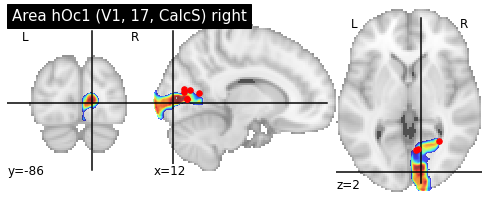

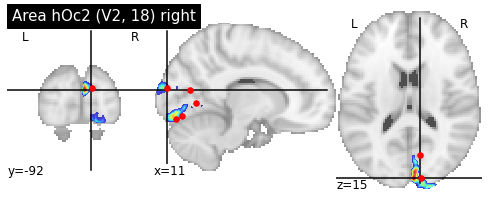

In [5]:
from nilearn import plotting

for regionname in candidate_regions:
    samples = jugex.get_samples(regionname)
    region = atlas.select_region(regionname)
    pmap = atlas.selected_region.get_regional_map(
        siibra.spaces.MNI152_2009C_NONL_ASYM, 
        siibra.MapType.CONTINUOUS)    
    # we could have also used the simple parcellation map mask as follows:
    # mask = atlas.get_mask(bs.spaces.MNI_152_ICBM_2009C_NONLINEAR_ASYMMETRIC)
    display = plotting.plot_roi(pmap.fetch(),cmap="jet",title=region.name)
    display.add_markers([s['mnicoord'] for s in samples.values()])